# Overview
This notebook is a short data analysis of the American Health Payments from 2011.<br>
It is the hard extension that we have - analysing a similar data set.<br>
Unfortunately, we could not find a file that specifies the values that each varaible may take. Therefor, we implemented an automatic determination for them. The process is very slow as it goes through all the values in each column and checks if it appears above.<br>
The two lines that do that are left in the notebook but commented out. This way the user can see how to use the functions but running the notebook will not be slowed down. We have supplied the outputs of those functions in the files "reformatted.csv" and "values.csv".<br>

# Imports

In [2]:
import csv
from pandas import DataFrame, read_csv
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets
from IPython.display import display, HTML
from textwrap import wrap
import numpy as np
from __future__ import print_function
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import reformat as rf

# Constants

In [3]:
rf.format_file()

output_file_path = "output.csv"
input_file_path = "reformatted.csv"

drgDef = 'DRG Definition'
providerId = 'Provider Id'
providerName = 'Provider Name'
providerStreet = 'Provider Street Address'
providerCity= 'Provider City'
providerState = 'Provider State'
providerZip = 'Provider Zip Code'
hospRef = 'Hospital Referral Region Description'
totalDischarges = ' Total Discharges '
avgCovered = ' Average Covered Charges '
avgTotal = ' Average Total Payments '
avgMedicare = 'Average Medicare Payments'

## List of headers and list of lists of possible values

In [4]:
header_list = [drgDef, providerId, providerName, providerStreet, providerCity,providerState, 
               providerZip, hospRef, totalDischarges, avgCovered, avgTotal, avgMedicare]

# Read the data set from the input file

In [5]:
dataSet = pd.read_csv(input_file_path, header=0)

# Data Refining
Drops invalid rows.

In [6]:
def refine_dataset(dataSet):
    """
        Prints type of each variable in the dataSet as well as the occurences of
        each unique value

        :param DataFrame dataSet: The DataFrame to refine
        :return: refined dataSet
        :rtype: DataFrame
    """
    #Drops rows with invalid number of variables
    dataSet.dropna(how='any')

    #Write updated dataset to file (For sake of testing comment this out, it's quite slow)
    dataSet.to_csv(output_file_path);

    return dataSet

dataSet = refine_dataset(dataSet)

# Create a list that contains all the unique values a variable can take.
def list_str(l):
    list_s = []
    for x in l:
        list_s.append(str(x))
    return list_s

variable_list = []
for h in header_list:
    variable_list.append(list_str(dataSet[h].unique().tolist()))

# Basic Data Analysis

In [7]:
def descriptive_analysis(dataSet):
    """
        Prints the number of records in a dataSet
        the type of each varaible
        and the occurrences of each unique value
        
        :param DataFrame dataSet: The DataFrame to print stats for
    """
    
    print("\nNumber of records: " + str(len(dataSet)) + "\n")
    
    #Seems janky but does the job,
    #removes person from list (Does not have any effect on given dataSet)
    for headerName in dataSet:
        # Get group for current header
        group = dataSet.groupby(headerName)

        # Print number of occurrences of each variable
        print(group.size())
        print("\n")

descriptive_analysis(dataSet)


Number of records: 163065

DRG Definition
039 - EXTRACRANIAL PROCEDURES W/O CC/MCC                                      1079
057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/O MCC                           1201
064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFARCTION W MCC                    1659
065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFARCTION W CC                     2269
066 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFARCTION W/O CC/MCC               1806
069 - TRANSIENT ISCHEMIA                                                      1962
074 - CRANIAL & PERIPHERAL NERVE DISORDERS W/O MCC                             979
101 - SEIZURES W/O MCC                                                        1593
149 - DYSEQUILIBRIUM                                                           988
176 - PULMONARY EMBOLISM W/O MCC                                              1396
177 - RESPIRATORY INFECTIONS & INFLAMMATIONS W MCC                            1894
178 - RESPIRATORY INFECTIONS & INFLAMMATIONS

# Data Plotting Method

In [8]:
# ensures plot will be shown in the jupyter notebook
%matplotlib notebook 

def plot_distribution_by_header(dataSet, header, plt_type, title, axis, *args):
    """
        Takes dataSet and then plots the distribution of given header

        :param DataFrame dataSet: The DataFrame to be plotted
        :param String header:     The header to plot
        :param String plt_type:   The type of plot (eg. "pie", "bar", etc)
        :param String title:      The plot title
        :param Axis axis:         The matplotlib axis to use
        :param *args              - each arg should be a touple of (filter_name, [filter_selection])
    """
    hd = str(header)
    pt = str(plt_type)
    tt = '\n'.join(wrap(str(title), 100))   # wrap long titles
    
    # filter dataset with filters provided in args
    for arg in args:
        dataSet = (dataSet[dataSet[arg[0]].isin(arg[1])])    
    
    # plot dataset and do per plot-type formatting
    if(pt == "pie"):
        dataSet[hd].value_counts().plot(ax=axis, kind=pt, autopct='%1.0f%%', pctdistance=0.8)
                                            # plots with % labels on pie chart slices
        axis.axis('equal')                  # Equal aspect ratio ensures that pie is drawn as a circle.
        axis.axis('off')                    # switches axis labels off
    if(pt == "bar") :
        
        dataSet[hd].value_counts().plot(ax=axis, kind=pt)
        axis.axis('auto')                   # resets axis labels back to auto
        axis.axis('on')
        plt.xticks(rotation=65, ha='right') # sets rotation and offset
        axis.set_xlabel(hd)
        axis.set_ylabel("Number of Records")
    if(pt == "hist"):
        n, bins, patches = plt.hist(dataSet[hd].value_counts(), 50, normed=1, facecolor='green', alpha=0.75)
    
    # adding padding beneath the plot title
    plt.title(tt, y=1.06)
    
    # wrapping of long axis labels
    oldXLabels = [ x.get_text() for x in axis.get_xticklabels() ]
    xLabels = [ '\n'.join(wrap(l, 30)) for l in oldXLabels ]
    axis.set_xticklabels(xLabels)
    
    #plt.tight_layout()
    
    # saving figure to file - all spaces replaced with '_'
    plt.savefig('Visualisations/' + title.replace(" ", "_") + '.png', bbox_inches='tight')
    
    # show plot in notebook
    plt.show()

# Bar chart - Records by Provider State

<IPython.core.display.Javascript object>


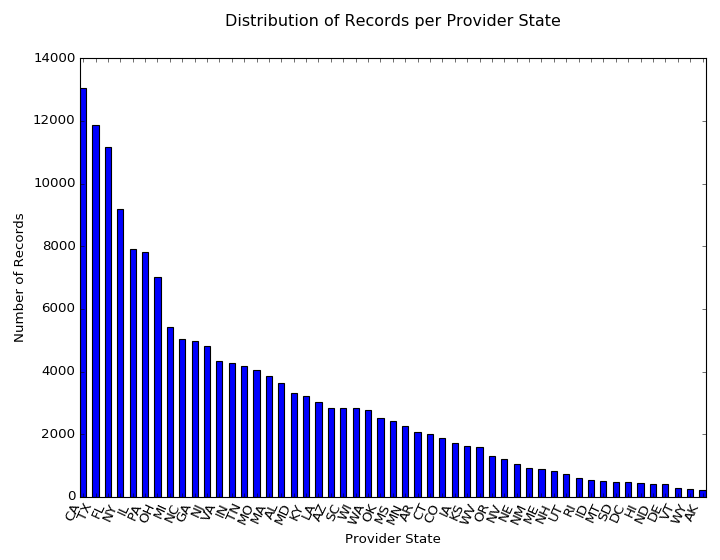

/usr/lib64/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


In [9]:
fig, axis = plt.subplots(figsize=(9, 7))
plot_distribution_by_header(dataSet, providerState, 'bar', "Distribution of Records per Provider State", axis)

# Interactive Plotter
This is essentially the same interactive plotter, adjusted for lists in this notebook.

<IPython.core.display.Javascript object>


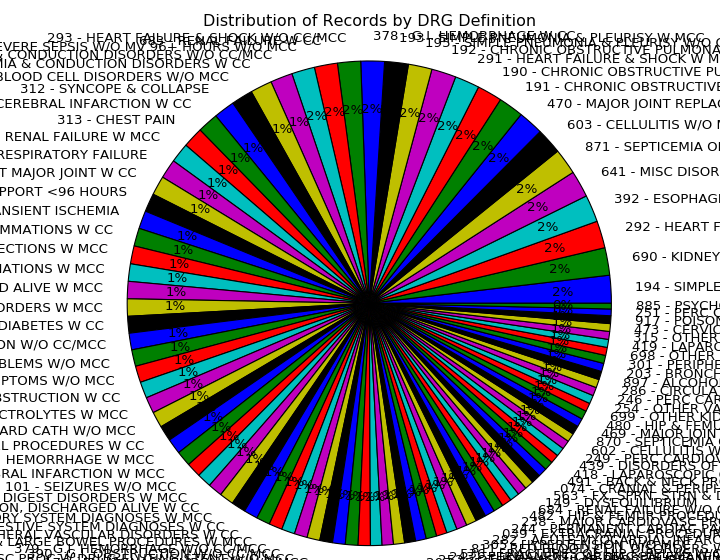

/usr/lib64/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


In [10]:
fig, axis = plt.subplots(figsize=(9, 7))

# lists storing filter widgets
filter_boxes = []
filter_selector_widgets = []
value_selector_widgets = []

def makeTitle(header, *args):
    """
        Function makes a human readable title from the header and filters provided. 
        Format:
            "Distribution of Records by <header> (for the <header> [<value>, ...] (and 
                the <header> [<value>, ...]), ...)
        
        :return: The title to put
        :rtype: string
    """
    ret = "Distribution of Records by " + header
    a = 0
    for arg in args:
        i = header_list.index(arg[0])
        allValues = variable_list[i]
        if(len(arg[1]) > 0 and len(arg[1]) < len(allValues)):
            if(a>0):
                ret += " and"
            else:
                ret += " for"
        if((len(arg[1]) > 1) and (len(arg[1]) < len(allValues))):
            ret += " the " + arg[0] + "[s] "
            i = 0
            for item in arg[1]:
                if(i>0):
                    ret+= ","
                ret += " '" + item + "'"
                i += 1
        elif(len(arg[1]) == 1):
            ret += " the " + arg[0] + " '" + arg[1][0] + "'"
        a += 1
    return ret

def update(b):
    """
        Called when "Update" is clicked. Clears previous and draws new plot. 
        Calls plot_distribution_by_header() with user selection.
    """
    axis.clear()
    filters = []
    for (f,s) in zip(filter_selector_widgets, value_selector_widgets):
        filters.append((f.value, s.value))
    plt_title = makeTitle(headerSelector.value, *filters);
    try:
        plot_distribution_by_header(dataSet, headerSelector.value, pltSelector.value, plt_title, axis, *filters)
    except:
        print("Plotting failed! Common error: conflicting filters!")

def removeFilter(b):
    """
        Called when "Remove Filter" is clicked. Tries to remove the last 
        set of filters in the lists.
    """
    try:
        filter_selector_widgets[-1].close()
        del filter_selector_widgets[-1]
        value_selector_widgets[-1].close()
        del value_selector_widgets[-1]
        filter_boxes[-1].close()
        del filter_boxes[-1]
    except:
        pass
    
def addFilter(b):
    """
        Called when "Add Filter" is clicked. Adds 2 new Selectors to the Controls.
    """
    
    # selector widget to chose header
    filter_selector_widget = widgets.Select(
        options=header_list,
        value=header_list[0],
        description='Header to filter:')
    
    # multi-selector widget to chose values
    value_selector_widget = widgets.SelectMultiple(
        options=variable_list[0],
        value=[variable_list[0][0]],
        description='Filter:')
    
    # handler function which updates the value_selector_widget
    def handle_chose(sender):
        """
            Called when a value in filter_selector_widget is clicked. Updates the 
            value_selector_widget.
        """
        i = header_list.index(filter_selector_widget.value)
        value_selector_widget.options=variable_list[i]
        value_selector_widget.value=[variable_list[i][0]]
    
    # register handler function
    filter_selector_widget.observe(handle_chose, names='value')
    
    # make vertival box for formatting
    filterControls = widgets.VBox([filter_selector_widget, value_selector_widget])
    
    # add widgets to list of all widgets
    filter_selector_widgets.append(filter_selector_widget)
    value_selector_widgets.append(value_selector_widget)
    filter_boxes.append(filterControls)

    # make new submit button and remove old ones
    global submit_new
    try:
        submit_new.close()
        submit.close()
        submitControl.close()
        submitControl_new.close()
    except:
        pass
    
    submit_new = widgets.Button(description="Update")
    submit_new.style.button_color = 'rosybrown'
    submit_new.on_click(update)
    submitControl_new = widgets.HBox([submit_new])
    display(filterControls, submitControl_new)

# control title
caption = widgets.Label(
    value='Interactive Plot Creator:',
    layout=Layout(width='160px'))

# plot type selector
pltSelector = widgets.Select(
    options=["pie", "bar", "hist"],
    value="pie",
    description='Plot Type:')

# header selector
headerSelector = widgets.Select(
    options=header_list,
    value=header_list[0],
    layout=Layout(color='#000000'),
    description='What to plot:')

pltControls = widgets.VBox([caption, pltSelector, headerSelector])

# 'add filter' button
addFilterButton = widgets.Button(description="Add Filter")
addFilterButton.style.button_color = 'forestgreen'
addFilterButton.on_click(addFilter)

# 'remove filter' button
removeFilterButton = widgets.Button(description="Remove Filter")
removeFilterButton.style.button_color = 'red'
removeFilterButton.on_click(removeFilter)
filterControls = widgets.HBox([addFilterButton, removeFilterButton])

# 'submit' button
submit = widgets.Button(description="Update")
submit.style.button_color = 'rosybrown'
submit.on_click(update)
submitControl = widgets.HBox([submit])

# display widgets
display(pltControls, filterControls, submitControl)